# Radiomics Univariable Analysis

In this notebook we perform the univariable analysis and use a "famous" rule of thumb of *n* observations per each feature included in the model to then compare with the model developed in the **Radiomics Features Model Development.ipynb**.

But first we need check and install any required libraries that may be missing.

## Check Environment and Install required libraries to execute notebooks


In [19]:
!python -c "import sklearn" || pip install --progress-bar off -q scikit-learn
!python -c "import matplotlib" || pip install --progress-bar off -q matplotlib
!python -c "import numpy" || pip install --progress-bar off -q numpy
!python -c "import pandas" || pip install --progress-bar off -q pandas
!python -c "import gdown" || pip install --progress-bar off -q gdown
!python -c "import statsmodels" || pip install --progress-bar off -q statsmodels
!python -c "import seaborn" || pip install --progress-bar off -q seaborn

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'seaborn'


## Import required libraries

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, balanced_accuracy_score, make_scorer, matthews_corrcoef

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.multitest import multipletests

### Check if needed files exist and download if not available

We will now download 2 files: a file containing the radiomic features and anoter file containing the corresponding labels.

In [5]:
if not os.path.isfile('output_t2w.csv'):
    !gdown --id 1fusKGIfs4EZBYm5h8e9MxtKIt3Puvr6l -q

if not os.path.isfile("PROSTATEx_Classes.csv"):
    !gdown --id 1kxSmF8iRmrLDqxkLvcTVvWPhD9H3tY7n -q

# Load radiomic features and labels files

We are going to partially print the labels and features

In [7]:
features_df = pd.read_csv('output_t2w.csv')
outcome_df = pd.read_csv('PROSTATEx_Classes.csv')
display(features_df.head())
display(outcome_df.head())

,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
0,ProstateX-0000,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
1,ProstateX-0001,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
2,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,165.913333,0.927322,6.703333,9.453333,53.716667,2.917303,0.328275,0.269131,2.160250,0.092260
3,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,132.917647,1.088904,7.250980,8.015686,54.501961,2.724523,0.340373,0.292592,2.382360,0.098212
4,ProstateX-0003,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361


,ID,Clinically Significant,Gleason Grade Group
0,ProstateX-0000_Finding1,True,3
1,ProstateX-0001_Finding1,False,1
2,ProstateX-0002_Finding1,True,2
3,ProstateX-0002_Finding2,False,1
4,ProstateX-0003_Finding1,False,No biopsy information


We want to predict the findings' clinical significance and a patient may have more than one lesion.

We will need to be carefull to split our dataset to ensure that we are not leaking data by having different findings of the same patient across different datasets.

To prevent this, and to ensure that we correctly match the findings' clinical significance to the corresponding radiomic features we will need to create some additional columns in the radiomic features and label dataframes.

In [8]:
# create a finding id for the radiomic features dataframe
features_df['FindingID'] = [os.path.basename(x)[:23].replace("-F","_F") for x in features_df['Mask']]

# create a finding id that will store the previous id from the outcome and then 
# update the ID to match to the id of the patient to ensure partition at the 
# patient level
outcome_df['FindingID'] = outcome_df['ID']
outcome_df['ID'] = outcome_df['ID'].str[:14]

## Set the finding as index column to easily merge the radiomics and outcome dataframes

In [9]:
features_df.set_index("FindingID", inplace=True)
outcome_df.set_index("FindingID", inplace=True)
features_outcome_df = pd.concat([outcome_df[["Clinically Significant"]], features_df], axis=1, join="inner")
display(features_outcome_df)

,Clinically Significant,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
FindingID,,,,,,,,,,,,,,,,,,,,,
ProstateX-0000_Finding1,True,ProstateX-0000,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
ProstateX-0001_Finding1,False,ProstateX-0001,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
ProstateX-0002_Finding1,True,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,165.913333,0.927322,6.703333,9.453333,53.716667,2.917303,0.328275,0.269131,2.160250,0.092260
ProstateX-0002_Finding2,False,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,132.917647,1.088904,7.250980,8.015686,54.501961,2.724523,0.340373,0.292592,2.382360,0.098212
ProstateX-0003_Finding1,False,ProstateX-0003,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ProstateX-0201_Finding1,True,ProstateX-0201,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1715.753219,1.247344,7.184366,7.707166,51.173762,3.138016,0.385975,0.278111,2.210073,0.093811
ProstateX-0202_Finding1,True,ProstateX-0202,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1254.959550,1.258851,7.109883,7.924937,51.534821,3.285643,0.394362,0.273947,2.197806,0.095511
ProstateX-0202_Finding2,False,ProstateX-0202,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,97.055096,0.998717,6.611570,9.936639,58.308540,2.987718,0.355257,0.264197,2.031158,0.103273


# Split Data

We will start by splitting the data into 2 separate sets.

1. Training dataset
2. Held-out test dataset

The training dataset will be used for the selection of the classifier algorithm we will use and its fine-tuning, while the held-out test dataset will be used to validade the model and assess its performance on unseen data.

Traditionally, in case the patients would only have one finding we could use the following function to split the data: 
```
test_prcntg = 0.25

random_state_value = 1 # necessary for reproducibility

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_prcntg,random_state=random_state_value, stratify=Y.to_list())
```

### But here because patients can have multiple lesions lets do a trick to create an held-out test datased comprising 25% (0.25)

We first create the group corresponding to the **PatientID**, the outcome *y* corresponding to the clinical significance of the finding, and the input *X* corresponding to the radiomic feature values of the findings

In [10]:
from sklearn.model_selection import StratifiedGroupKFold
y = features_outcome_df["Clinically Significant"]
groups = features_outcome_df.ID
X = features_outcome_df.drop(['Clinically Significant', 'ID', 'Image', 'Mask',
                              'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 
                              'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 
                              'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 
                              'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 
                              'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 
                              'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 
                              'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 
                              'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 
                              'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 
                              'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 
                              'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 
                              'diagnostics_Image-interpolated_Spacing', 'diagnostics_Image-interpolated_Size', 
                              'diagnostics_Image-interpolated_Mean', 'diagnostics_Image-interpolated_Minimum', 
                              'diagnostics_Image-interpolated_Maximum', 'diagnostics_Mask-interpolated_Spacing', 
                              'diagnostics_Mask-interpolated_Size', 'diagnostics_Mask-interpolated_BoundingBox', 
                              'diagnostics_Mask-interpolated_VoxelNum', 'diagnostics_Mask-interpolated_VolumeNum', 
                              'diagnostics_Mask-interpolated_CenterOfMassIndex', 'diagnostics_Mask-interpolated_CenterOfMass', 
                              'diagnostics_Mask-interpolated_Mean', 'diagnostics_Mask-interpolated_Minimum', 
                              'diagnostics_Mask-interpolated_Maximum',], axis=1)

Using the **StratifiedGroupKFold** with `n_splits=4` we can use the first fold to define our Training and Held-out test set with guaranties that no patient findings are present in both dataset and that proportion of clinically significant findings are maintained. 

In [11]:
# define random state variable for reproducibility
random_state_value = 1

print_information = False

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state_value)
sgkf.split(X, y, groups)
train_index, test_index = next(sgkf.split(X, y, groups))
if print_information:
    print(f"  Train: index={train_index}")
    print(f"         size={len(train_index)}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         size={len(test_index)}")
    print(f"         group={groups[test_index]}")

X_train = X.iloc[train_index]
Y_train = y.iloc[train_index]

X_test = X.iloc[test_index]
Y_test = y.iloc[test_index]

# Transform Clinically Significant labels from True/False to 1/0 using LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

display(X_train)
display(Y_train)
display(y_train)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
FindingID,,,,,,,,,,,,,,,,,,,,,
ProstateX-0000_Finding1,0.381395,0.274926,5.154447,18.748495,12.528368,14.312233,11.818629,21.633308,358.5600,7.150591,...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
ProstateX-0001_Finding1,0.720671,0.328547,5.576379,16.972871,15.367498,15.000000,18.000000,19.809089,538.9650,12.231856,...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
ProstateX-0003_Finding1,0.860427,0.431030,9.756535,22.635417,25.377943,22.641555,24.782252,26.084478,1818.6750,19.476117,...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361
ProstateX-0003_Finding2,0.683300,0.569478,10.117343,17.765995,18.973666,17.492856,19.944924,20.827866,1396.8000,12.139499,...,350.805619,1.341682,7.386484,7.192863,48.501139,3.212789,0.398196,0.288101,2.372246,0.093649
ProstateX-0004_Finding1,0.740195,0.425276,14.609209,34.352264,35.986247,37.206048,32.255232,43.636338,7772.6925,25.427363,...,1275.033849,1.303118,7.310423,7.771930,52.407637,3.315094,0.392818,0.270701,2.184457,0.091820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ProstateX-0201_Finding1,0.871546,0.382889,13.266557,34.648607,33.776323,35.323646,36.840195,42.485762,7075.9350,30.197851,...,1715.753219,1.247344,7.184366,7.707166,51.173762,3.138016,0.385975,0.278111,2.210073,0.093811
ProstateX-0202_Finding1,0.801186,0.602560,15.685827,26.031984,30.558796,26.318055,25.827892,33.136083,5137.8300,20.856453,...,1254.959550,1.258851,7.109883,7.924937,51.534821,3.285643,0.394362,0.273947,2.197806,0.095511
ProstateX-0202_Finding2,0.457748,0.375179,5.822668,15.519716,15.367498,12.924396,9.767292,16.099689,374.4000,7.104114,...,97.055096,0.998717,6.611570,9.936639,58.308540,2.987718,0.355257,0.264197,2.031158,0.103273


FindingID
ProstateX-0000_Finding1     True
ProstateX-0001_Finding1    False
ProstateX-0003_Finding1    False
ProstateX-0003_Finding2    False
ProstateX-0004_Finding1    False
                           ...  
ProstateX-0201_Finding1     True
ProstateX-0202_Finding1     True
ProstateX-0202_Finding2    False
ProstateX-0203_Finding1     True
ProstateX-0203_Finding2     True
Name: Clinically Significant, Length: 230, dtype: bool

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

## Perform univariable analysis on training set
### A little bit about metrics
Metrics play a very important role in the development and performance of our model. Its the optimization metric that allows us to select the proper classifier among several other options and train/fine-tune the classifier hyper-parameters to obtain our final model.

Different metrics provide different information on the classification performance and may depend on the properties of our dataset (e.g., are the classes in our dataset balanced or not).

In many applications we will deal with unbalanced datasets. In this situation one can either upsample the under-represented class (which has risks due to the generation of data that has not been observed) or downsample the over-represented class (which will discard information that was collected and may be usefull).

Another option is to try to pick a better optimization metric that tries to overcome the unbalance of our dataset.

Accuracy is know to be a bad metric for optimization of classifiers using data with unbalanced classes/outcomes. 

Metrics like F1-score, Balanced Accuracy, Cohen's Kappa and Matthews Correlation Coefficient have been suggested to better deal with unbalanced datasets.

# Perform univariable analysis on training set

Using the training part of our data we will determine the predictive power of each radiomic features. We will obtain the Area Under the Receiver Operating Characteristic curve (AUC), the optimal threshold for the classification for which sensitivity and specificity are calculated, and p-value of the statistical test to assess if the  distributions of the positive and negative cases are significantly. 

In [15]:
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

feature_names, sensitivity_list, specificity_list, auc_list, threshold_list, test_type_list, pvalue_list, pos_vs_neg_list = ([] for i in range(8))
for column in X_train:
  # normality test
  stat, p = shapiro(X_train[column])
  # print('Name ', column)
  # print('Statistics=%.3f, p=%.3f' % (stat, p))
  a_dist = X_train[column][y_train==0]
  b_dist = X_train[column][y_train==1]
  feature_names.append(column)
  # interpret
  alpha = 0.05
  if p > alpha:
    test_type_list.append('t-test')
    stats, pval = ttest_ind(a_dist, b_dist)
    # print('Sample looks Gaussian (fail to reject H0)')
  else:
    test_type_list.append('mann-whitney U-test')
    stats, pval = mannwhitneyu(a_dist, b_dist)
    # print('Sample does not look Gaussian (reject H0)')
  pvalue_list.append(pval)
  fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], pos_label=1)
  auc = metrics.auc(fpr, tpr)
  pos_vs_neg = ">"
  if auc <0.5:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], 
                                             pos_label=0)
    auc = metrics.auc(fpr, tpr)
    pos_vs_neg = "<"
  auc_list.append(auc)
  pos_vs_neg_list.append(pos_vs_neg)
  ####################################
  # The optimal cut off would be where tpr is high and fpr is low
  # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
  ####################################
  i = np.arange(len(tpr)) # index for df
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  cutoff_df = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

  sensitivity_list.append(cutoff_df['tpr'].values[0])
  specificity_list.append(cutoff_df['1-fpr'].values[0])
  threshold_list.append(cutoff_df['thresholds'].values[0])

train_auc_pvals_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list,threshold_list, 
                                           sensitivity_list, specificity_list, 
                                           test_type_list, pvalue_list)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value'])

train_auc_pvals_df.sort_values(by='p-value', ascending=True)

/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/var/folders/1h/5r1_h3k53gx5k92ps_3wvvs40000gn/T/ipykernel_19996/982112011.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats, pval = ttest_ind(a_dist, b_dist)


,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value
wavelet2-LL_gldm_LargeDependenceHighGrayLevelEmphasis,0.654693,>,10556.892027,0.660377,0.666667,mann-whitney U-test,0.000776
wavelet2-LL_glszm_LargeAreaHighGrayLevelEmphasis,0.649976,>,8830.450199,0.622642,0.647436,mann-whitney U-test,0.001120
wavelet2-LL_gldm_LargeDependenceLowGrayLevelEmphasis,0.637034,<,0.002234,0.641026,0.622642,mann-whitney U-test,0.002908
wavelet2-LL_glcm_JointAverage,0.635462,>,74.066574,0.622642,0.628205,mann-whitney U-test,0.003249
wavelet2-LL_glcm_SumAverage,0.635462,>,148.133149,0.622642,0.628205,mann-whitney U-test,0.003249
...,...,...,...,...,...,...,...
squareroot_glrlm_HighGrayLevelRunEmphasis,0.500484,<,1712.425588,0.512821,0.528302,mann-whitney U-test,0.992659
lbp-2D_firstorder_90Percentile,0.500121,>,9.000000,0.981132,0.019231,mann-whitney U-test,0.995581
wavelet2-HH_glcm_JointEnergy,0.500242,>,0.021772,0.490566,0.500000,mann-whitney U-test,0.996854
square_gldm_GrayLevelVariance,0.500000,<,3.752477,0.493590,0.490566,mann-whitney U-test,1.000000


Lets count how many features are statistically significant between groups

In [16]:
print(sum(i < 0.05 for i in train_auc_pvals_df['p-value']))

363


# Jackpot!!!!!!!

Well... not really...

We are assessing 1037 radiomic so the chance of finding a feature that appears to statistically discriminate between outcomes is very large. The procedure to correct for this increase in chance is called multiple comparisons . There are two types of corrections: family-wise error rate (FWER) and false discovery rate (FDR). FWER are more conservative than FDR methods. Bonferroni is a well known FWER while the Benjamini–Hochberg procedure is a widely use FDR correction. In this case, we will be conservative and, therefore, use the Benjamini–Hochberg procedure andobtain the corrected p-values.

We added the corrected p-value to our univariable performance table (dataframe).



In [17]:
_, corrected_p_value, _, _ = multipletests(train_auc_pvals_df['p-value'], 
                                           alpha=0.05, method='bonferroni')

train_auc_pvals_corrected_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list, 
                                                     threshold_list, 
                                                     sensitivity_list, 
                                                     specificity_list, 
                                                     test_type_list, 
                                                     pvalue_list, 
                                                     corrected_p_value)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value',
                                            'corrected p-value'])
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)

,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value,corrected p-value
original_shape_Elongation,0.549347,>,0.730859,0.528302,0.519231,mann-whitney U-test,0.284038,1.0
square_glcm_Idn,0.546323,>,0.935752,0.528302,0.525641,mann-whitney U-test,0.314623,1.0
square_glcm_Idmn,0.580310,>,0.985224,0.566038,0.564103,mann-whitney U-test,0.081106,1.0
square_glcm_Idm,0.503024,>,0.577191,0.471698,0.480769,mann-whitney U-test,0.948645,1.0
square_glcm_Id,0.501814,>,0.617645,0.490566,0.487179,mann-whitney U-test,0.969592,1.0
...,...,...,...,...,...,...,...,...
wavelet-HL_glrlm_LongRunHighGrayLevelEmphasis,0.597847,>,714.226532,0.566038,0.576923,mann-whitney U-test,0.033545,1.0
wavelet-HL_glrlm_LongRunEmphasis,0.517175,<,1.172438,0.480769,0.471698,mann-whitney U-test,0.709897,1.0
wavelet-HL_glrlm_GrayLevelVariance,0.501935,<,35.155183,0.557692,0.528302,mann-whitney U-test,0.967496,1.0
lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,0.531084,<,0.098830,0.538462,0.547170,mann-whitney U-test,0.500106,1.0


In [18]:
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True).index[0:20]

Index(['original_shape_Elongation', 'square_glcm_Idn', 'square_glcm_Idmn',
       'square_glcm_Idm', 'square_glcm_Id', 'square_glcm_DifferenceVariance',
       'square_glcm_DifferenceEntropy', 'square_glcm_DifferenceAverage',
       'square_glcm_Correlation', 'square_glcm_Contrast', 'square_glcm_Imc1',
       'square_glcm_ClusterTendency', 'square_glcm_ClusterProminence',
       'square_glcm_Autocorrelation', 'square_firstorder_Variance',
       'square_firstorder_Uniformity', 'square_firstorder_TotalEnergy',
       'square_firstorder_Skewness', 'square_firstorder_RootMeanSquared',
       'square_firstorder_RobustMeanAbsoluteDeviation'],
      dtype='object')

# Visualizations of discriminative power of radiomic features

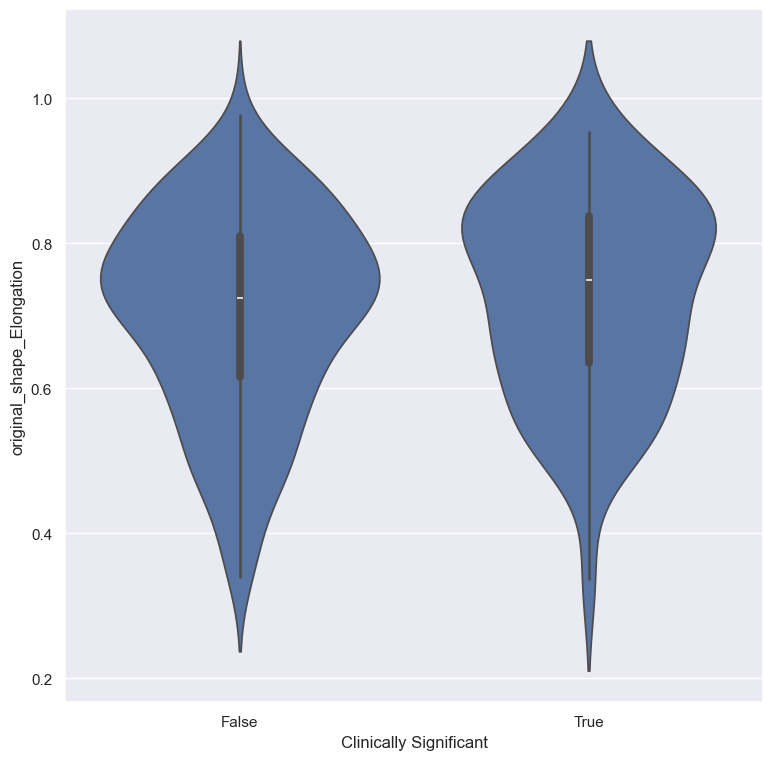

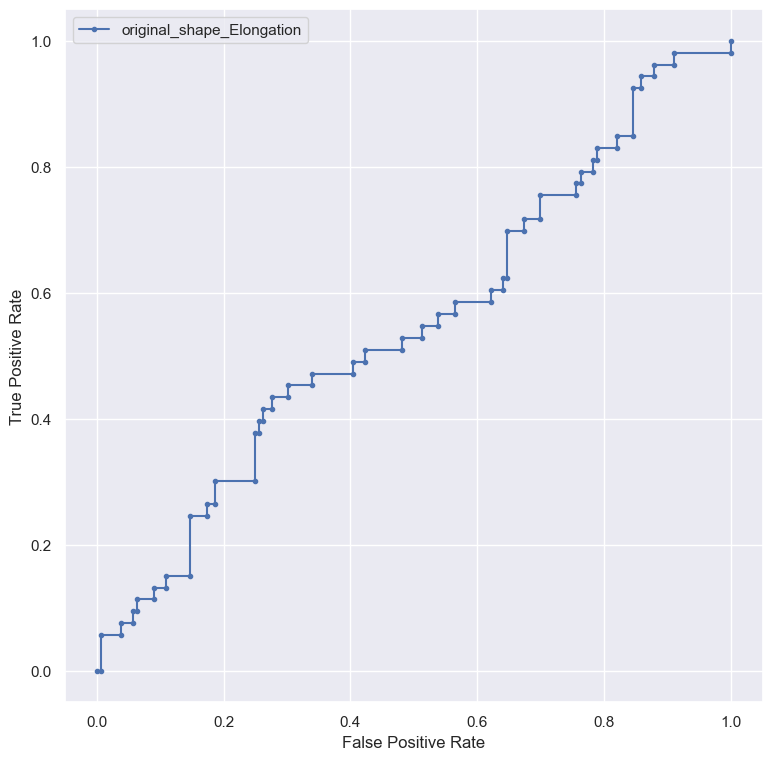

In [20]:
dropdown = 'original_shape_Elongation' 

import seaborn as sns
from matplotlib import pyplot
from sklearn.metrics import roc_curve
sns.set(rc={'figure.figsize':(9,9)})
sns.violinplot(x=Y_train, y=X_train[dropdown])

plt.figure(0)
lr_fpr, lr_tpr, _ = roc_curve(Y_train, X_train[dropdown])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label=dropdown)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Lets count how many features are statistically significant between groups after the multiple comparisons correction


In [21]:
print(sum(i < 0.05 for i in corrected_p_value))

0


It seems that after correcting for the multiple comparisons no feature remains statistically significant. Nonetheless, we will try to use the best features to create a multivariable model.

# Lets train a model using 1 feature for every 15 patients we have on the training set

We will use the best features, according to the univariable analysis on the training set

In [22]:
num_features_model = round(X_train[dropdown].shape[0]/15)
train_df = train_auc_pvals_df.sort_values(by='p-value', ascending=True)
selected_features = train_df.index[0:num_features_model]

X_train_new = X_train[selected_features]

### Check the selected features

In [43]:
selected_features

Index(['wavelet2-LL_gldm_LargeDependenceHighGrayLevelEmphasis',
       'wavelet2-LL_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet2-LL_gldm_LargeDependenceLowGrayLevelEmphasis',
       'wavelet2-LL_glcm_JointAverage', 'wavelet2-LL_glcm_SumAverage',
       'wavelet2-LL_glcm_Autocorrelation',
       'wavelet2-LL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet2-LL_glrlm_LongRunHighGrayLevelEmphasis',
       'wavelet2-LL_gldm_SmallDependenceLowGrayLevelEmphasis',
       'wavelet2-LL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet2-LL_glrlm_LongRunLowGrayLevelEmphasis',
       'wavelet2-LL_glszm_LowGrayLevelZoneEmphasis',
       'log-sigma-3-mm-3D_glszm_ZoneEntropy',
       'log-sigma-3-mm-3D_glrlm_RunEntropy'],
      dtype='object')

# Select optimization metric

Note: We will have a deeper look at metric in the next part of the model development


In [23]:
optimization_metric = "AUC" #["AUC", "MCC", "Kappa","F1", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "BalancedAcc"]

if optimization_metric == "AUC":
    score_str = 'roc_auc'
elif optimization_metric == "MCC":
    score_str = make_scorer(matthews_corrcoef)
elif optimization_metric == "Kappa":
    score_str = make_scorer(cohen_kappa_score)
elif optimization_metric == "F1":
    score_str = 'f1'
elif optimization_metric == "Accuracy":
    score_str = 'accuracy'
elif optimization_metric == "Sensitivity":
    score_str = 'recall'
elif optimization_metric == "Specificity":
    score_str = make_scorer(recall_score, pos_label=0)
elif optimization_metric == "PPV":
    score_str = 'precision'
elif optimization_metric == "NPV":
    score_str = make_scorer(precision_score, pos_label=0)
elif optimization_metric == "BalancedAcc":
    score_str = 'balanced_accuracy'

score_group = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef) ,
               'Kappa': make_scorer(cohen_kappa_score), 
               'F1': 'f1', 'Accuracy': 'accuracy', 
               'Sensitivity': 'recall', 
               'Specificity': make_scorer(recall_score, pos_label=0),
               'PPV': 'precision', 
               'NPV': make_scorer(precision_score, pos_label=0),
               'BalancedAcc': 'balanced_accuracy'}

score_refit_str = optimization_metric

# Classifier Selection

When trying to compare and select among several classifiers, the recommended approach select the best classifier method is by using the nested cross-validation. This proceedure consist of an outer k-fold cross-validation loop to splipt the data into training and test folds, and an inner k-fold cross-validation loop on the training fold, as shown the figure below.

![](https://drive.google.com/uc?export=view&id=10IZjGrPq7xBWPslhlNPBqwb-9qx7Mevx)

Below you can select the models to be compared (the more you select  the longer the execution time)

In [24]:
SVM_classifier = True
LogisticRegression_classifier = True
RandomForest_classifier = True
NaiveBayes_classifier = False
KNN_classifier = False
GradientBoosting_classifier = False

# Run and Compare Classifiers

In [26]:
df_ncv_scores = pd.DataFrame(columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
if SVM_classifier:
    pipe_svc = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             SVC(random_state=random_state_value))

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_grid_svc = [{'svc__C': param_range, 
                  'svc__kernel': ['linear']},
                  {'svc__C': param_range, 
                  'svc__gamma': param_range, 
                  'svc__kernel': ['rbf']}]

    gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_scv = cross_val_score(gs_svc, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['SVM'], 'Nested-CV Mean': [np.mean(scores_scv)], 'Nested-CV Std': [np.std(scores_scv)]}, columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)
    
if LogisticRegression_classifier:
    pipe_lr = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            LogisticRegression(random_state=random_state_value, #penalty='elasticnet', 
                                           solver='saga'))

    param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_range_penalty = ['l1']

    param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                     'logisticregression__C': param_range_lr,
                     }

    gs_lr = GridSearchCV(estimator=pipe_lr, 
                      param_grid=param_grid_lr, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_lr = cross_val_score(gs_lr, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Nested-CV Mean': [np.mean(scores_lr)], 'Nested-CV Std': [np.std(scores_lr)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if RandomForest_classifier:
    pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

    param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                    'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    gs_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=param_grid_rf, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_rf = cross_val_score(gs_rf, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Nested-CV Mean': [np.mean(scores_rf)], 'Nested-CV Std': [np.std(scores_rf)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if NaiveBayes_classifier:
    pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GaussianNB())

    param_grid_nb = {}

    gs_nb = GridSearchCV(estimator=pipe_nb, 
                      param_grid=param_grid_nb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_nb = cross_val_score(gs_nb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Nested-CV Mean': [np.mean(scores_nb)], 'Nested-CV Std': [np.std(scores_nb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if KNN_classifier:
    pipe_knn = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

    param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

    param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                    'kneighborsclassifier__weights': ['uniform', 'distance']}

    gs_knn = GridSearchCV(estimator=pipe_knn, 
                      param_grid=param_grid_knn, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_knn = cross_val_score(gs_knn, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['KNN'], 'Nested-CV Mean': [np.mean(scores_knn)], 'Nested-CV Std': [np.std(scores_knn)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if GradientBoosting_classifier:
    pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GradientBoostingClassifier(random_state=random_state_value))

    param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

    param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                    'gradientboostingclassifier__learning_rate': param_learnrate_gb}

    gs_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=param_grid_gb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_gb = cross_val_score(gs_gb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Nested-CV Mean': [np.mean(scores_gb)], 'Nested-CV Std': [np.std(scores_gb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

df_ncv_scores.sort_values(by=df_ncv_scores.columns[1], ascending=False)


/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Conver

,Classifier,Nested-CV Mean,Nested-CV Std
2,Random Forest,0.658095,0.083892
0,SVM,0.585674,0.158772
1,Logistic Regression,0.547590,0.030916


## Select classifier to train/fine-tune model

In [36]:
selected_model = 'RandomForest'

number_folds = 5

## Train/Fine-tune selected model

In [37]:
if selected_model == 'SVM':
  pipe_svc = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           SVC(random_state=random_state_value))

  param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_grid_svc = [{'svc__C': param_range, 
                'svc__kernel': ['linear']},
                {'svc__C': param_range, 
                'svc__gamma': param_range, 
                'svc__kernel': ['rbf']}]

  gs_svc = GridSearchCV(estimator=pipe_svc, 
                    param_grid=param_grid_svc, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_svc.fit(X_train_new, y_train)
  clf_svc = gs.best_estimator_
          
elif selected_model == 'LogisticRegression':
  pipe_lr = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          LogisticRegression(penalty='elasticnet', random_state=random_state_value,
                                            solver='saga'))

  param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_l1_ratio_lr = np.linspace(0,1,11)

  param_range_penalty = ['l1']

  param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                   'logisticregression__C': param_range_lr}

  gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_lr.fit(X_train_new, y_train)
  clf_lr = gs.best_estimator_

elif selected_model == 'RandomForest':
  pipe_rf = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

  param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                  'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

  gs_rf = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid_rf, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_rf.fit(X_train_new, y_train)
  clf_rf = gs.best_estimator_

elif selected_model == 'NaiveBayes':
  pipe_nb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GaussianNB())

  param_grid_nb = {}

  gs_nb = GridSearchCV(estimator=pipe_nb, 
                    param_grid=param_grid_nb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_nb.fit(X_train_new, y_train)
  clf_nb = gs.best_estimator_
  
elif selected_model == 'KNN':
  pipe_knn = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

  param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

  param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                  'kneighborsclassifier__weights': ['uniform', 'distance']}

  gs_knn = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid_knn, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_knn.fit(X_train_new, y_train)
  clf_knn = gs.best_estimator_
  
elif selected_model == 'GradientBoosting':
  pipe_gb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GradientBoostingClassifier(random_state=random_state_value))

  param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
  param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

  param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                  'gradientboostingclassifier__learning_rate': param_learnrate_gb}

  gs_gb = GridSearchCV(estimator=pipe_gb, 
                    param_grid=param_grid_gb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_gb.fit(X_train_new, y_train)
  clf_gb = gs.best_estimator_

print(gs.best_params_)
for key in score_group:
    if len(gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1])>1:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1][0],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1][0]))
    else:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1]))


/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 32}
CV AUC: 0.677 +/- 0.076
CV MCC: 0.320 +/- 0.084
CV Kappa: 0.276 +/- 0.067
CV F1: 0.387 +/- 0.066
CV Accuracy: 0.780 +/- 0.023
CV Sensitivity: 0.344 +/- 0.109
CV Specificity: 0.974 +/- 0.038
CV PPV: 0.830 +/- 0.236
CV NPV: 0.795 +/- 0.022
CV BalancedAcc: 0.614 +/- 0.031


# Assess Model performance on the held-out test dataset

### Obtain the univariable performance of the best 5 features on the test set 

We will do this using the cut-off thresholds of these features on the training set


In [38]:
train_metrics_df = train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)
train_metrics_df.head()

auc_test_list, sens_test_list, spec_test_list = ([] for i in range(3))
for indx in range(5):
  feature_name = train_metrics_df.index[indx]
  if train_metrics_df.iloc[indx]['Pos.vs.Neg.'] == '>':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=1)
    pred = np.zeros(X_test[feature_name].shape)
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=0)
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  auc = metrics.auc(fpr, tpr)
  tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
  sensitivity = tp / (tp+fn)
  specificity = tn / (tn+fp)
  auc_test_list.append(auc)
  sens_test_list.append(sensitivity)
  spec_test_list.append(specificity)

test_auc_pvals_df = pd.DataFrame(list(zip(auc_test_list, 
                                           sens_test_list, spec_test_list)), 
                                  index = train_metrics_df.index[0:5],
                                  columns =['AUC', 'Sensitivity', 
                                            'Specificity'])
test_auc_pvals_df


,AUC,Sensitivity,Specificity
original_shape_Elongation,0.563271,0.565217,0.671642
square_glcm_Idn,0.417910,0.347826,0.447761
square_glcm_Idmn,0.456846,0.434783,0.477612
square_glcm_Idm,0.441921,0.478261,0.477612
square_glcm_Id,0.440623,0.478261,0.477612


### Plot Confusion Matrix of tuned model on held-out test dataset prediction

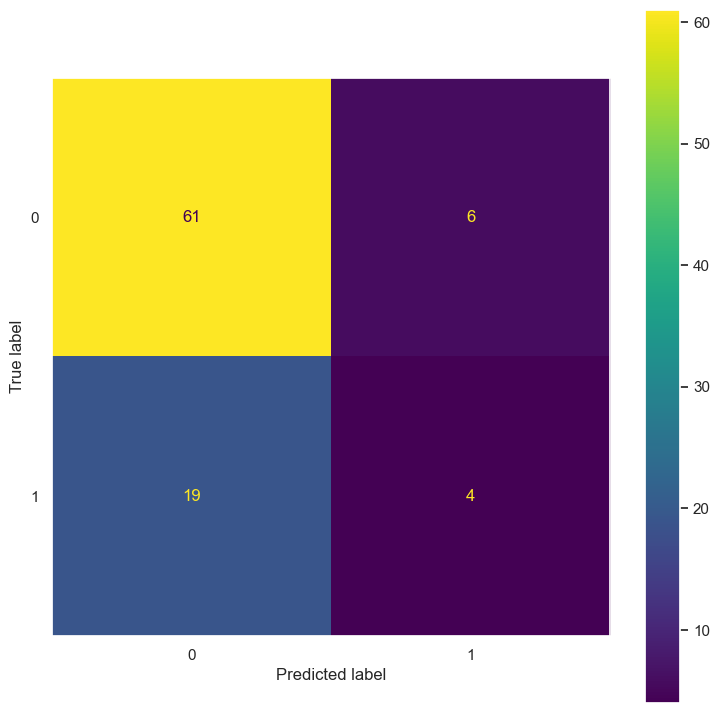

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gs, X_test[selected_features], y_test)
plt.grid(None)
plt.show()

### Obtain performance metrics of model on the held-out test set

In [40]:
clf = gs
print('AUC: %.3f' % (roc_auc_score(y_test, clf.predict(X_test[selected_features]))))
print('MCC: %.3f' % (matthews_corrcoef(y_test, clf.predict(X_test[selected_features]))))
print('Kappa: %.3f' % (cohen_kappa_score(y_test, clf.predict(X_test[selected_features]))))
print('F1: %.3f' % (f1_score(y_test, clf.predict(X_test[selected_features]))))
print('Accuracy: %.3f' % (accuracy_score(y_test, clf.predict(X_test[selected_features]))))
print('Sensitivity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]))))
print('Specificity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('PPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]))))
print('NPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('BalancedAcc: %.3f\n\n' % (balanced_accuracy_score(y_test, clf.predict(X_test[selected_features]))))

AUC: 0.542
MCC: 0.117
Kappa: 0.104
F1: 0.242
Accuracy: 0.722
Sensitivity: 0.174
Specificity: 0.910
PPV: 0.400
NPV: 0.762
BalancedAcc: 0.542




# Additional Notes and Resources

- F1-score vs Balanced Accuracy - https://stats.stackexchange.com/questions/49579/balanced-accuracy-vs-f-1-score


> 1.   If N >> P, F1-score is a better.
> 2.   If P >> N, Balanced Accuracy is better.
> 
> N - number of cases in the negative class;
> P - number of cases in the positive class

- Upsampling/Downsampling - https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data

> "For up-/downsampling: I think there is no canonical answer to "if those are required". They are more one way of adapting your problem. Technically: yes, you could use them, but use them with care, especially upsampling (you might end up creating unrealistic samples without noticing it) - and be aware that changing the frequency of samples of both classes to something not realistic "in the wild" might have negative effects on prediction performance as well. At least the final, held-out test set should reflect the real-life frequency of samples again. Bottom line: I've seen both cases where doing and not doing up-/or downsampling resulted in the better final outcomes, so this is something you might need to try out (but don't manipulate your test set(s)!)."

- The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation 
> https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7 

- Why Cohen’s Kappa should be avoided as performance measure in classification 
> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916

- How to chose your classifier from a set of possible options:
> - Raschka S, Mirjalili V. **Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2**. 2019. Packt Publishing.
> - Varma S, Simon R. **Bias in error estimation when using cross-validation for model selection**. BMC bioinformatics. 2006 Dec 1;7(1):91.